In [19]:
import h5py
import json
import numpy as np
from nltk.tokenize import word_tokenize
from collections import Counter
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

def read_files():
    datastore={}
    visual_feat_mapping={}
    img_feat_data={}
    img_features = np.asarray(h5py.File('IR_image_features.h5', 'r')['img_features'])

    with open('IR_img_features2id.json', 'r') as f:
        visual_feat_mapping = json.load(f)['IR_imgid2id']

    with open("IR_train_easy.json") as tweetfile:
        datastore = json.load(tweetfile)
    for key in visual_feat_mapping.keys():
        h5_id = visual_feat_mapping[key]
        img_feat = img_features[h5_id]
        img_feat_data[key]=img_feat    
        
    return datastore,visual_feat_mapping,img_feat_data   
def create_vocab(datastore):
    w2i={}
    i2w={}
    counter=Counter()
    di={}
    for i in range(0,40000):
        dialogs=datastore[str(i)]['dialog']
        for dialog in dialogs:
            for line in dialog:
                tokens=word_tokenize(line)
                for token in tokens:
                    counter[token]+=1
    index=0      
    counter=counter.most_common(500)
    for key in counter:
        w2i[key[0]]=index
        i2w[index]=key[0]
        index+=1
    w2i["invalid"]=index
    i2w[index]="invalid"
    return w2i,i2w    

datastore,visual_feat_mapping,img_feat_data=read_files()
w2i,i2w=create_vocab(datastore)
print("Complete")


Complete


In [112]:
dtype = torch.FloatTensor
learning_rate =0.0009
def create_nueral_net():
    errors=[]
    w_in = Variable(torch.randn(501,1).type(dtype),requires_grad=True)
    w_out = Variable(torch.randn(1,2048).type(dtype),requires_grad=True)
    loss =nn.CrossEntropyLoss()
    m = nn.Softmax()
    #text_input=torch.Tensor(len(w2i))
    #img_input=torch.Tensor(2048)
    for epochs in range(0,30):
        error=0 
        print("epoch "+str(epochs))
        start=0
        end=400
        for loop in range(0,1):
            for i in range(start,end):  
                #print(i)
                dialogs=datastore[str(i)]['dialog']
                text_inputs=torch.Tensor(len(dialogs),len(w2i),1)
                index=0
                image_index=datastore[str(i)]['target']
                for dialog in dialogs:
                    for line in dialog:
                        text_input=torch.zeros(len(w2i),1)
                        tokens=word_tokenize(line)
                        for token in tokens:
                            if token in w2i.keys():
                               text_input[w2i[token]]=text_input[w2i[token]]+1.0
                            else:
                               text_input[w2i["invalid"]]=text_input[w2i["invalid"]]+1.0   
                        text_inputs[index]=text_input
                        index=index+1
                images_arr=datastore[str(i)]['img_list']
                image_data=torch.Tensor(2048,1)
                images=torch.Tensor(len(images_arr),2048,1)
                for k in range(0,len(images_arr)):
                    image_data=img_feat_data[str(images_arr[k])]
                    images[k]=torch.from_numpy(image_data)
                index=0
           
                y_target =Variable(torch.zeros(1).type(torch.LongTensor), requires_grad=False)
                y_predict =Variable(torch.zeros(1,10), requires_grad=False)
                for k in range(0,len(images_arr)):
                    
                    input_data=Variable(torch.zeros(2048,501), requires_grad=False)
                    hidden_layer_sum=Variable(torch.zeros(2048,1), requires_grad=True)
                    hidden_layer_data=Variable(torch.zeros(2048,1), requires_grad=True)
            
                    if(k==image_index):
                       y_target.data[0]=k
                    for j in range(0,len(text_inputs)):
                        temp=text_inputs[j].transpose(0,1)
                        temp2=images[k].mm(temp)
                        input_data.data=temp2
                        hidden_layer_data=input_data.mm(w_in)
                        hidden_layer_sum= hidden_layer_sum+hidden_layer_data
                    hidden_layer_sum=torch.div(hidden_layer_sum, len(text_inputs))
                    temp_output=w_out.mm(hidden_layer_sum)
                    y_predict[0,k]=temp_output
                   
                #print(y_predict.type)
                #print(y_target.type)
                y_predict=m(y_predict)
                loss_for_image = loss( y_predict,y_target)
                error=error+loss_for_image
                loss_for_image.backward()
                w_in.data -= learning_rate * w_in.grad.data
                w_out.data -= learning_rate * w_out.grad.data
                    #print(error)   
                w_in.grad.data.zero_()
                w_in.grad.data.zero_()
            
            #start=start+5000
            #end=end+5000
            print(error)  
            errors.append(error)
            

    return w_in,w_out,errors        

w_in,w_out,errors=create_nueral_net()

print("Input Done")

epoch 0
Variable containing:
 470.8598
[torch.FloatTensor of size 1]

epoch 1
Variable containing:
 465.5178
[torch.FloatTensor of size 1]

epoch 2
Variable containing:
 457.4916
[torch.FloatTensor of size 1]

epoch 3
Variable containing:
 452.7193
[torch.FloatTensor of size 1]

epoch 4
Variable containing:
 444.7437
[torch.FloatTensor of size 1]

epoch 5
Variable containing:
 437.3271
[torch.FloatTensor of size 1]

epoch 6
Variable containing:
 428.6427
[torch.FloatTensor of size 1]

epoch 7
Variable containing:
 417.2307
[torch.FloatTensor of size 1]

epoch 8
Variable containing:
 412.3379
[torch.FloatTensor of size 1]

epoch 9
Variable containing:
 410.6841
[torch.FloatTensor of size 1]

epoch 10
Variable containing:
 408.2955
[torch.FloatTensor of size 1]

epoch 11
Variable containing:
 410.3102
[torch.FloatTensor of size 1]

epoch 12
Variable containing:
 412.9070
[torch.FloatTensor of size 1]

epoch 13
Variable containing:
 415.1518
[torch.FloatTensor of size 1]

epoch 14
Variabl

In [115]:
m = nn.Softmax()
def preditct_values(w_in,w_out):
    count=0
    for i in range(0,100):  
        #print(i)
        dialogs=datastore[str(i)]['dialog']
        text_inputs=torch.Tensor(len(dialogs),len(w2i),1)
        index=0
        image_index=datastore[str(i)]['target']
        for dialog in dialogs:
            for line in dialog:
                text_input=torch.zeros(len(w2i),1)
                tokens=word_tokenize(line)
                for token in tokens:
                    if token in w2i.keys():
                       text_input[w2i[token]]=text_input[w2i[token]]+1.0
                    else:
                       text_input[w2i["invalid"]]=text_input[w2i["invalid"]]+1.0   
                text_inputs[index]=text_input
                index=index+1
        images_arr=datastore[str(i)]['img_list']
        image_data=torch.Tensor(2048,1)
        images=torch.Tensor(len(images_arr),2048,1)
        for k in range(0,len(images_arr)):
            image_data=img_feat_data[str(images_arr[k])]
            images[k]=torch.from_numpy(image_data)
        index=0
   
        y_target =Variable(torch.zeros(1).type(torch.LongTensor), requires_grad=False)
        y_predict =Variable(torch.zeros(1,10), requires_grad=False)
        for k in range(0,len(images_arr)):
            
            input_data=Variable(torch.zeros(2048,501), requires_grad=False)
            hidden_layer_sum=Variable(torch.zeros(2048,1), requires_grad=True)
            hidden_layer_data=Variable(torch.zeros(2048,1), requires_grad=True)
    
            if(k==image_index):
               y_target.data[0]=k
            for j in range(0,len(text_inputs)):
                temp=text_inputs[j].transpose(0,1)
                temp2=images[k].mm(temp)
                input_data.data=temp2
                hidden_layer_data=input_data.mm(w_in)
                hidden_layer_sum= hidden_layer_sum+hidden_layer_data
            hidden_layer_sum=torch.div(hidden_layer_sum, len(text_inputs))
            temp_output=w_out.mm(hidden_layer_sum)
            y_predict[0,k]=temp_output
        y_predict=m(y_predict)
        max1=y_predict[0,0].data[0]
        #print(max1)
        pos=1
        for l in range(1,10):
            if(y_predict[0,l].data[0]>max1):
                max1=y_predict[0,l].data[0]
                pos=l
        if(pos==y_target.data[0]):
            count=count+1
    print(count)  
                
preditct_values(w_in,w_out)    

33


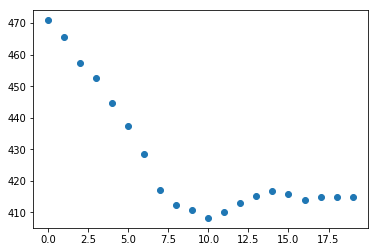

In [116]:


x=np.zeros(len(errors))
y=np.zeros(len(errors))
for i in range(0,len(errors)):
    x[i]=i
    y[i]=errors[i].data[0]
plt.scatter(x,y)

plt.show()

Variable containing:
 2
 4
 0
[torch.LongTensor of size 3]

